# Cross Sectional Factors Demo

This notebook demonstrates a toy example of how to create cross-sectional single and composite factors using the `CrossSectionalFactor` and `CompositeCrossSectionalFactor` classes.

____

In [24]:
# imports
import numpy as np 
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from src.factors.characteristic_config import CharacteristicConfig
from src.factors.cross_sectional_characteristic import CrossSectionalCharacteristic
from src.factors.composite_cross_sectional_factor import CompositeCrossSectionalFactor

/Users/MilesChild/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Establish Factor Data

### Momentum

We will construct a composite momentum factor from two characteristics:
- 9 month trailing return
- 12 month trailing return

We will equal weight the two characteristics in the composite factor.
_____

In [31]:
# toy example data

# """OPTION 1: Define dummy values"""

# # characteristic 1: 9 month trailing return
# TRAILING_9MO_RETURNS = np.array([
#     0.15, 0.08, -0.12, 0.25, 0.05, 
#     -0.03, 0.18, 0.11, -0.07, 0.21,
#      0.09, -0.15, 0.13, 0.07, -0.09, 
#      0.22, 0.04, -0.06, 0.16, -0.11, 
#      0.19, 0.06, -0.08, 0.14, 0.50
#     ])

# # characteristic 2: 12 month trailing return
# TRAILING_12MO_RETURNS = np.array([
#     0.20, 0.12, -0.08, 0.30, 0.10,
#     -0.05, 0.25, 0.15, -0.04, 0.28, 
#     0.14, -0.10, 0.18, 0.11, -0.06,
#     0.27, 0.08, -0.03, 0.22, -0.07,
#     0.24, 0.09, -0.05, 0.19, 0.45
#     ])

"""OPTION 2: Get random values. This is a better simulation of large datasets"""

np.random.seed(42)

def sample_returns(n_securities, mean=0.001, std=0.02, skew_factor=-0.3):
    """Not important. Just for getting sample return values for demo"""
    # start with gauss
    base_returns = np.random.normal(mean, std, n_securities)
    
    # make less gauss
    n_extremes = n_securities // 10
    extreme_indices = np.random.choice(n_securities, n_extremes, replace=False)
    
    # make even less gauss
    negative_extremes = np.random.normal(-3*std, 2*std, n_extremes//2)
    positive_extremes = np.random.normal(2*std, 1.5*std, n_extremes - n_extremes//2)
    base_returns[extreme_indices[:n_extremes//2]] = negative_extremes
    base_returns[extreme_indices[n_extremes//2:]] = positive_extremes
    
    # add a skew
    base_returns += skew_factor * (base_returns ** 2)
    
    return base_returns

# Generate returns
n_securities = 100
TRAILING_9MO_RETURNS = sample_returns(
    n_securities,
    mean=0.001,
    std=0.02,
    skew_factor=-0.3
)

TRAILING_12MO_RETURNS = sample_returns(
    n_securities,
    mean=0.0012,
    std=0.024,
    skew_factor=-0.3
)

In [32]:
"""First, define the config parameters for the Momentum Characteristics"""
momentum_t9m_config = CharacteristicConfig(
    name="TSR(9M)",  # total shareholder return over the last 9 months
    log_raw_values=False,
    winsorize_raw_values=True,
    weight=0.5
)
momentum_t12m_config = CharacteristicConfig(
    name="TSR(12M)",  # total shareholder return over the last 12 months
    log_raw_values=False,
    winsorize_raw_values=True,
    weight=0.5
)
"""Next, create the characteristic objects by loading in the raw values and config we already defined"""
momentum_t9m_characteristic = CrossSectionalCharacteristic(
    raw_vector=TRAILING_9MO_RETURNS,
    config=momentum_t9m_config
)
momentum_t12m_characteristic = CrossSectionalCharacteristic(
    raw_vector=TRAILING_12MO_RETURNS,
    config=momentum_t12m_config
)

We can easily visualize the loadings on each security for each characteristic.

We can also check the distribution of the raw return values against the distribution of the loadings to ensure the data has been 'normalized' well.

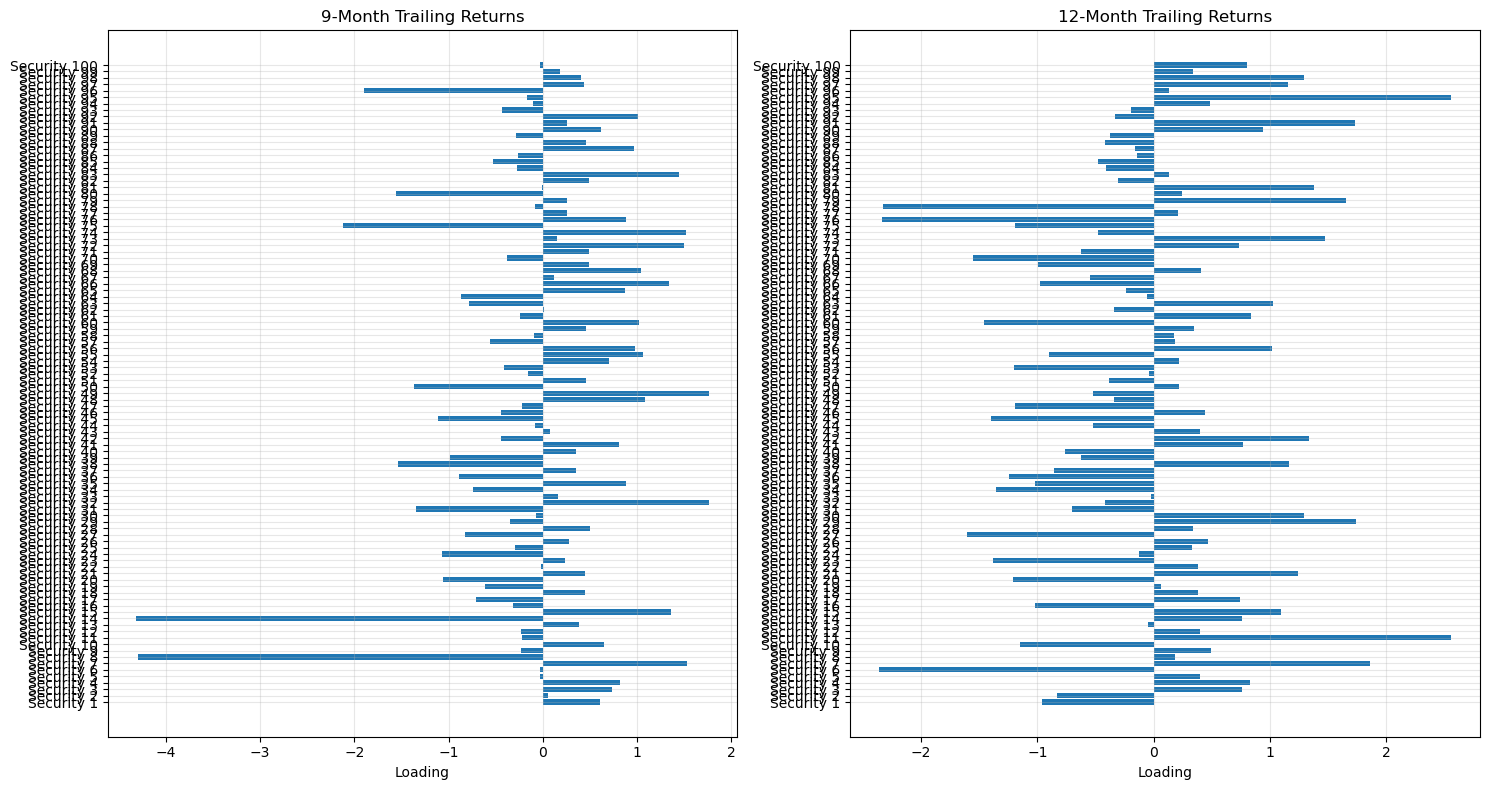

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
securities = [f'Security {i+1}' for i in range(len(TRAILING_9MO_RETURNS))]

# 9-month trailing returns
ax1.barh(securities, momentum_t9m_characteristic.get_loadings())
ax1.set_title('9-Month Trailing Returns')
ax1.set_xlabel('Loading')
ax1.grid(True, alpha=0.3)

# 12-month trailing returns
ax2.barh(securities, momentum_t12m_characteristic.get_loadings())
ax2.set_title('12-Month Trailing Returns')
ax2.set_xlabel('Loading')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

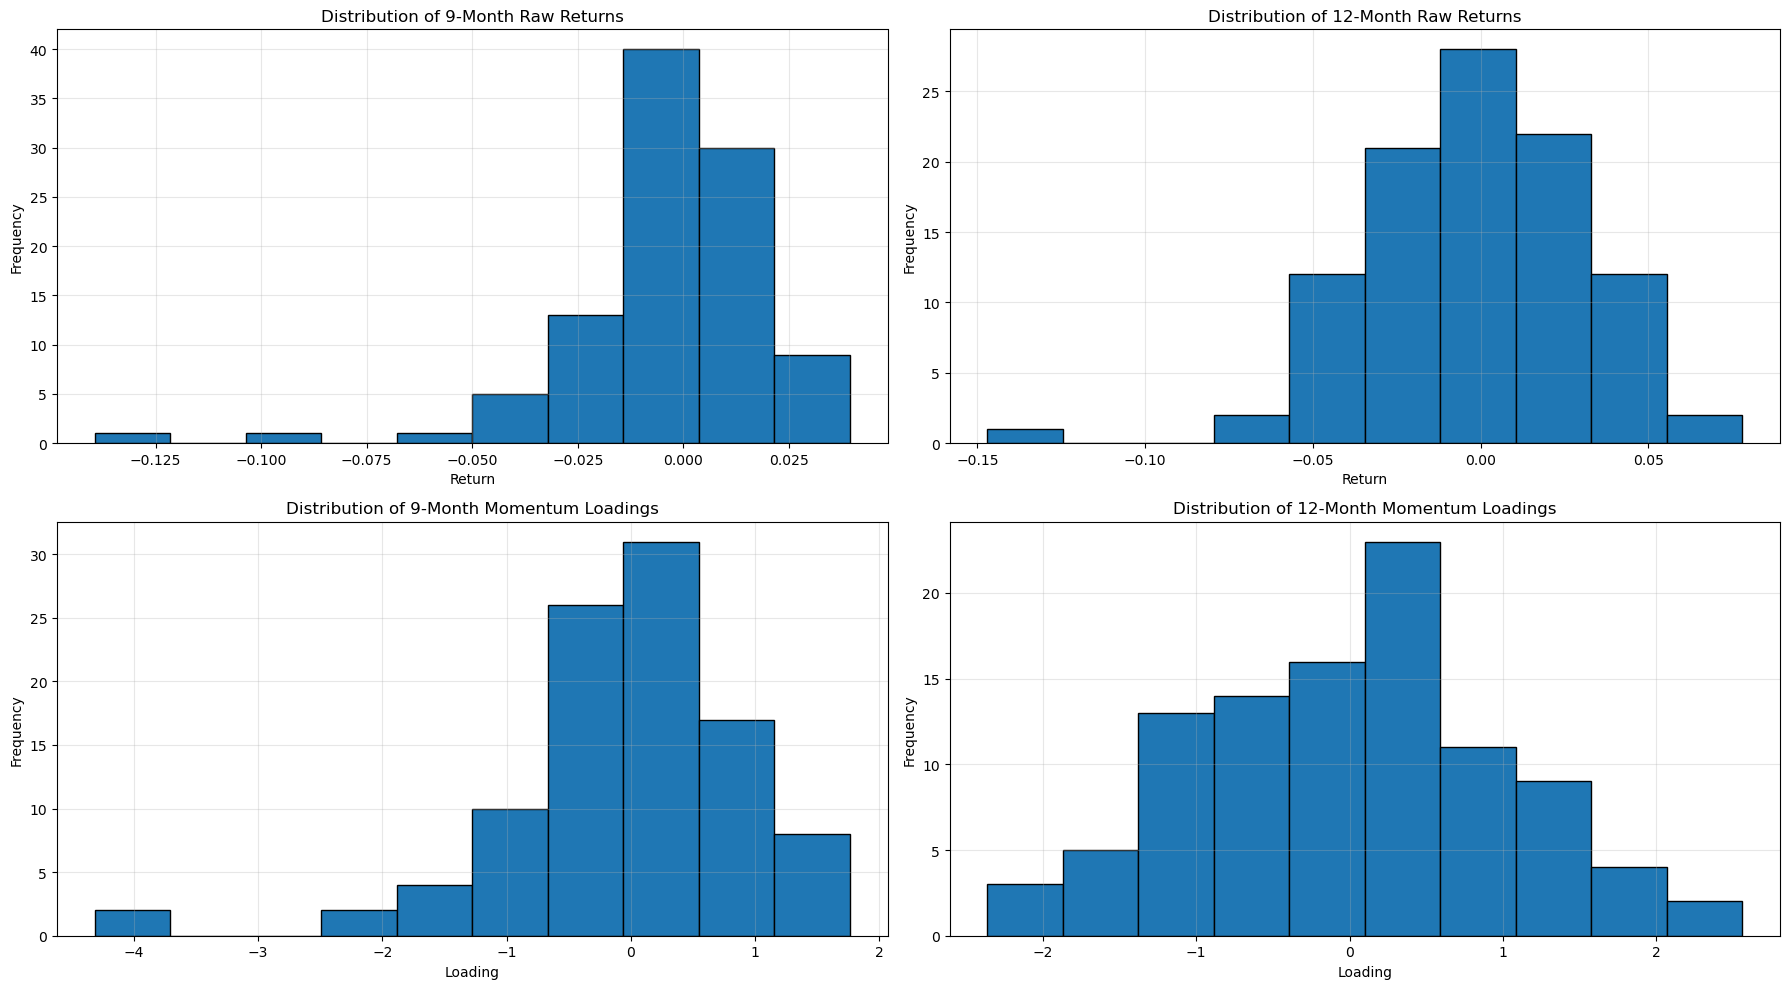

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

axes[0,0].hist(TRAILING_9MO_RETURNS, bins=10, edgecolor='black')
axes[0,0].set_title('Distribution of 9-Month Raw Returns')
axes[0,0].set_xlabel('Return')
axes[0,0].set_ylabel('Frequency')
axes[0,0].grid(True, alpha=0.3)

axes[0,1].hist(TRAILING_12MO_RETURNS, bins=10, edgecolor='black')
axes[0,1].set_title('Distribution of 12-Month Raw Returns')
axes[0,1].set_xlabel('Return')
axes[0,1].set_ylabel('Frequency')
axes[0,1].grid(True, alpha=0.3)

# Second row: Factor Loadings Distributions
# 9-month momentum loadings
axes[1,0].hist(momentum_t9m_characteristic.get_loadings(), bins=10, edgecolor='black')
axes[1,0].set_title('Distribution of 9-Month Momentum Loadings')
axes[1,0].set_xlabel('Loading')
axes[1,0].set_ylabel('Frequency')
axes[1,0].grid(True, alpha=0.3)

# 12-month momentum loadings
axes[1,1].hist(momentum_t12m_characteristic.get_loadings(), bins=10, edgecolor='black')
axes[1,1].set_title('Distribution of 12-Month Momentum Loadings')
axes[1,1].set_xlabel('Loading')
axes[1,1].set_ylabel('Frequency')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

To combine the two characteristics into a single, composite factor, we can use the `CompositeCrossSectionalFactor` class.

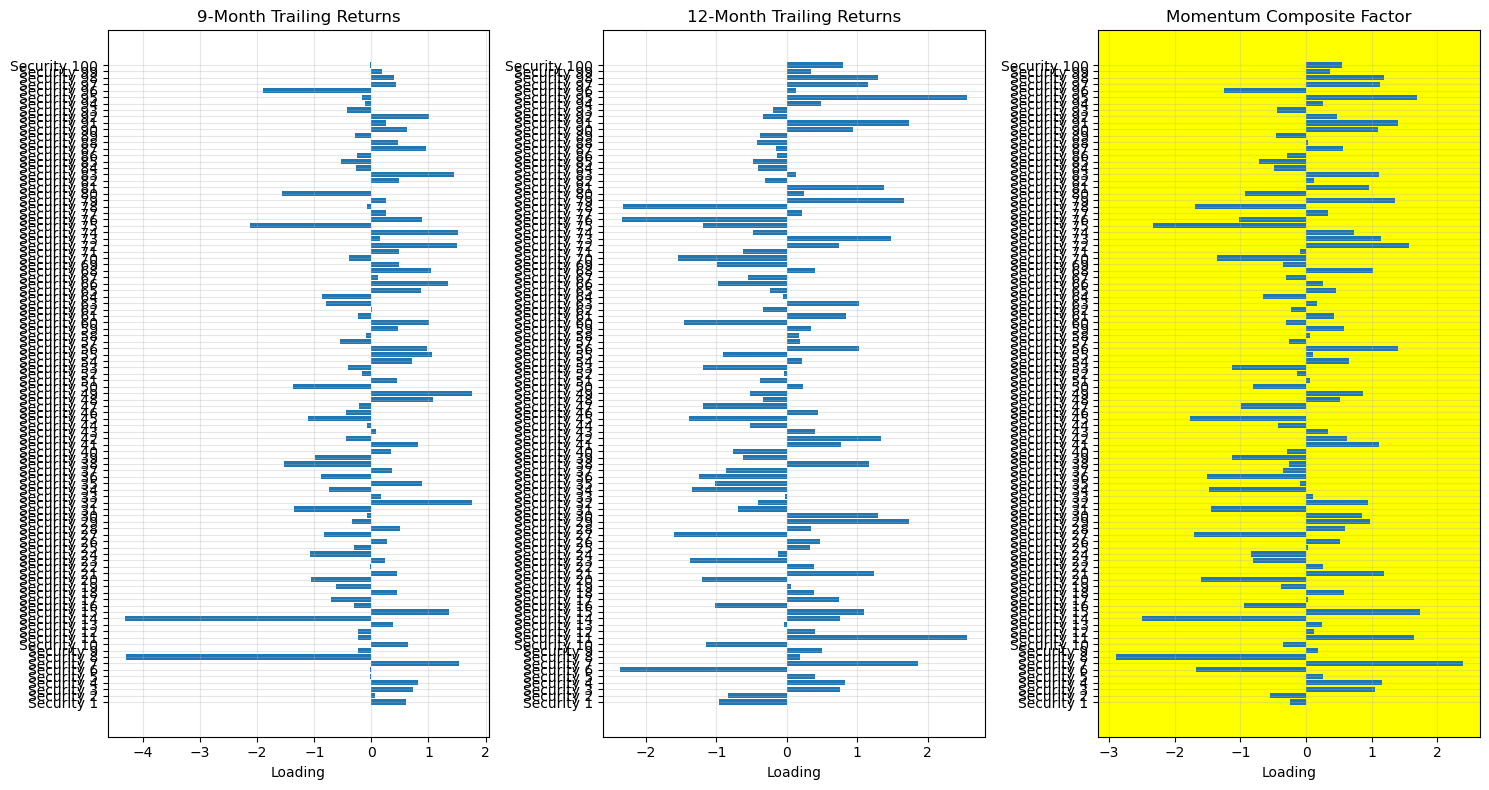

In [35]:
momentum_composite_factor = CompositeCrossSectionalFactor(
    characteristics=[momentum_t9m_characteristic, momentum_t12m_characteristic],
    name="Momentum"
)
momentum_composite_factor.process_loadings()
momentum_loadings = momentum_composite_factor.get_loadings()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))
securities = [f'Security {i+1}' for i in range(len(TRAILING_9MO_RETURNS))]

# 9-month trailing returns
ax1.barh(securities, momentum_t9m_characteristic.get_loadings())
ax1.set_title('9-Month Trailing Returns')
ax1.set_xlabel('Loading')
ax1.grid(True, alpha=0.3)

# 12-month trailing returns
ax2.barh(securities, momentum_t12m_characteristic.get_loadings())
ax2.set_title('12-Month Trailing Returns')
ax2.set_xlabel('Loading')
ax2.grid(True, alpha=0.3)

# Composite factor
ax3.barh(securities, momentum_loadings)
ax3.set_title('Momentum Composite Factor')
ax3.set_xlabel('Loading')
ax3.grid(True, alpha=0.3)
ax3.set_facecolor('yellow')

plt.tight_layout()
plt.show()